In a [previous post](https://www.datacamp.com/community/tutorials/pandas-split-apply-combine-groupby), you saw how the groupby operation arises naturally through the lens of the principle of split-apply-combine. You checked out a dataset of Netflix user ratings and grouped the rows by the release year of the movie to generate the following figure:

<p align="center">
<img src="img/netflix_median.png" width="350">
</p>

This was achieved via grouping by a single column. I mentioned, in passing, that you may want to group by several columns, in which case the resulting pandas DataFrame ends up with a multi-index _or_ hierarchical index. In this post, you'll learn what _hierarchical indices_ and see how they arise when grouping by several features of your data. You can find out more about all of these concept and practices in our [Manipulating DataFrames with pandas course](https://www.datacamp.com/courses/manipulating-dataframes-with-pandas), taught by Dhavide Aruliah of Anaconda Inc. (I also had the great pleasure of working on this course with Dhavide and his team).


So first up: what are hierarchical indices?

## Hierarchical indices and pandas DataFrames

### What is the index of a DataFrame?

Before introducing hierarchical indices, I want you to recall what the index of pandas DataFrame is. The index of a DataFrame is a set that consists of a label for each row. Let's look at an example. I'll first import a synthetic dataset of a hypothetical DataCamp student Ellie's activity on DataCamp. The columns are a date, a programming language and the number of exercises that Ellie completed that day in that language. Load in the data:

In [1]:
# Import pandas
import pandas as pd

# Load in data
df = pd.read_csv('data/user_ex_python.csv')
df

,date,language,ex_complete
0,2017-01-01,python,6
1,2017-01-02,python,5
2,2017-01-03,python,10


You can see the Index on the left hand side of the DataFrame and that it consists of integers. This is a `RangeIndex`:

In [2]:
# Check out index
df.index

RangeIndex(start=0, stop=3, step=1)

We can use this index to slice out a row or rows of `df`:

In [3]:
# Slice and dice data
df.loc[:1]

,date,language,ex_complete
0,2017-01-01,python,6
1,2017-01-02,python,5


This index, however, is not so informative. If you're going to label the rows of your DataFrame, it would be good to label them in a meaningful manner, if at all possible. Can you do this with the dataset in question? A good way to think about this challenge is that you want a **unique _and_ meaningful identifier for each row**. Check out the columns and see if any matches these criteria. Notice that the `date` column contains unique dates so it makes sense to label each row by the date column. That is,you can make the `date` column the index of the DataFrame using the `.set_index()` method (n.b. `inplace=True` means you're actually altering the DataFrame `df` inplace):

In [4]:
# Set new index
df.set_index(pd.DatetimeIndex(df['date']), inplace=True)
df

,date,language,ex_complete
date,,,
2017-01-01,2017-01-01,python,6
2017-01-02,2017-01-02,python,5
2017-01-03,2017-01-03,python,10


This then gives `df` a `DateTimeIndex`:

In [5]:
# Check out new index
df.index

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03'], dtype='datetime64[ns]', name='date', freq=None)

Now you can slice out rows using the `DateTimeIndex` that you've created:

In [6]:
# Slice and dice data w/ new index
df.loc['2017-01-02']

date           2017-01-02
language           python
ex_complete             5
Name: 2017-01-02 00:00:00, dtype: object

Also note that the `.columns` attribute returns an index containg the column names of `df`:

In [7]:
# Check out columns
df.columns

Index(['date', 'language', 'ex_complete'], dtype='object')

This can be slightly confusing because this says is that `df.columns` is of type `Index`. This **does not mean** that the columns are the index of the DataFrame. The index of `df` is always given by `df.index`. Check out our [pandas DataFrames tutorial](https://www.datacamp.com/community/tutorials/pandas-tutorial-dataframe-python) for more on indices. Now it's time to meet hierarchical indices.

### The Multi-index of a pandas DataFrame

What if we had multiple languages for our dataset, as we do on DataCamp? Have a look:

In [8]:
# Import and check out data
df = pd.read_csv('data/user_ex.csv')
df

,date,language,ex_complete
0,2017-01-01,python,6
1,2017-01-02,python,5
2,2017-01-03,python,10
3,2017-01-01,r,8
4,2017-01-02,r,8
5,2017-01-03,r,8


Each date now corresponds to several rows, one for each language. See, for example, that the date '2017-01-02' occurs in rows 1 and 4, for languages Python and R, respectively. Thus the date no longer *uniquely* specifies the row. However, 'date' and 'language' together do uniquely specify the rows. For this reason, we use both as the index:

In [9]:
# Set index
df.set_index(['date', 'language'], inplace=True)
df

,,ex_complete
date,language,
2017-01-01,python,6
2017-01-02,python,5
2017-01-03,python,10
2017-01-01,r,8
2017-01-02,r,8
2017-01-03,r,8


You have now created a multi-index, or hierarchical index (become comfortable with both these terms as you'll find them used interchangeably), and you can see this by checking out the index as follows:

In [10]:
# Check out multi-index
df.index

MultiIndex(levels=[['2017-01-01', '2017-01-02', '2017-01-03'], ['python', 'r']],
           labels=[[0, 1, 2, 0, 1, 2], [0, 0, 0, 1, 1, 1]],
           names=['date', 'language'])

The above tells you that your DataFrame `df` now has a `MultiIndex` with two _levels_, the first given by the date, the second by the the language. Recall that above you were able to slice the DataFrame using the index and the `.loc` accessor: `df.loc['2017-01-02']`. To be able to slice with a multi-index, you need to sort the index first:

In [11]:
# Sort index
df.sort_index(inplace=True)
df

ex_complete
date       language             
2017-01-01 python              6
           r                   8
2017-01-02 python              5
           r                   8
2017-01-03 python             10
           r                   8

Now you can slice out the number of R exercises completed on 2017-01-02 by passing a tuple to the `.loc` accessor:

In [12]:
# Slice & dice your DataFrame
df.loc[('2017-01-02', 'r')]

ex_complete    8
Name: (2017-01-02, r), dtype: int64

You now know a bit about hierarchical indices (or multi-indices). It's time to see how they arise when working with groupby objects.

___

## Hierarchical indices, groupby objects and split-apply-combine

In [a previous post](https://www.datacamp.com/community/tutorials/pandas-split-apply-combine-groupby), we explored groupby objects and the data analytic principles of split-apply-combine using netflix data. Lets have a quick refresher with a different dataset, the tips dataset that is built into the `seaborn` package. 'Tips' contains features such as tip, total_bill, the day of the week and the time of day. First load and explore the data:

In [13]:
# Import and check out data
import seaborn as sns
tips = sns.load_dataset("tips")
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


Note that the index of `tips` is a `RangeIndex`:

In [14]:
# Check out index
tips.index

RangeIndex(start=0, stop=244, step=1)

It always helps to do some visual EDA before diving into computation and seaborn's pairplot function allows you to get an overview of all numerical variables:

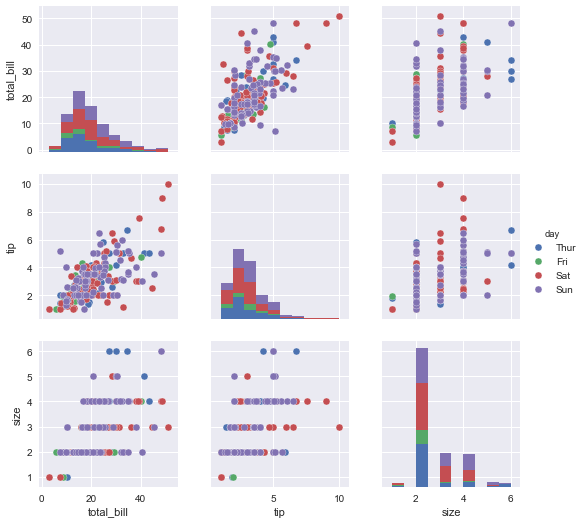

In [15]:
# Import pyplot, figures inline, set style, plot pairplot
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
sns.pairplot(tips, hue='day');

If you want to check out how the average tip differs between 'smokers' and 'non-smokers', you can **split** the original DataFrame by the 'smoker' (using `groupby`), **apply** the function 'mean' and **combine** into a new DataFrame:

In [16]:
# Get mean of smoker/non-smoker groups
df = tips.groupby('smoker').mean()
df

,total_bill,tip,size
smoker,,,
Yes,20.756344,3.008710,2.408602
No,19.188278,2.991854,2.668874


The resulting index of the DataFrame `df` is the 'smoker' column/feature of the original 'tips' DataFrame: 

In [17]:
# Check out new index
df.index

CategoricalIndex(['Yes', 'No'], categories=['Yes', 'No'], ordered=False, name='smoker', dtype='category')

If desired, you can reset the index so that 'smoker' becomes a column of the DataFrame:

In [18]:
# Reset the index
df.reset_index()

,smoker,total_bill,tip,size
0,Yes,20.756344,3.008710,2.408602
1,No,19.188278,2.991854,2.668874


Now it's time to find out how hierarchical indices arise from split-apply-combine and groupby operations.

### Multiple groupings and hierarchical indices

Above, you grouped the tips dataset according to the feature 'smoker'. Sometimes you will need to group a dataset according to two features.  For example, it is natural to group the tips dataset into  smokers/non-smokers & dinner/lunch. To do this, you pass the column names you wish to group by as a list:

In [19]:
# Group by two columns
df = tips.groupby(['smoker','time']).mean()
df

total_bill       tip      size
smoker time                                  
Yes    Lunch    17.399130  2.834348  2.217391
       Dinner   21.859429  3.066000  2.471429
No     Lunch    17.050889  2.673778  2.511111
       Dinner   20.095660  3.126887  2.735849

Looking at the above, you may be able to see that both 'smoker' and 'time' are indices of `df`. This is the case and makes sense: if grouping by 'smoker' results in the index being the original 'smoker' column, grouping by two columns will give you two indices. Check the index to confirm that it's hierarchical:

In [20]:
# Check out index
df.index

MultiIndex(levels=[['Yes', 'No'], ['Lunch', 'Dinner']],
           labels=[[0, 0, 1, 1], [0, 1, 0, 1]],
           names=['smoker', 'time'])

And it is. You can do a bunch of useful things now, such as getting the counts in each grouping:

In [21]:
# Group by two features
tips.groupby(['smoker','time']).size()

smoker  time  
Yes     Lunch      23
        Dinner     70
No      Lunch      45
        Dinner    106
dtype: int64

You can swap the levels of the hierarchical index also so that 'time' occurs before 'smoker' in the index:

In [22]:
# Swap levels of multi-index
df.swaplevel()

,,total_bill,tip,size
time,smoker,,,
Lunch,Yes,17.399130,2.834348,2.217391
Dinner,Yes,21.859429,3.066000,2.471429
Lunch,No,17.050889,2.673778,2.511111
Dinner,No,20.095660,3.126887,2.735849


You may then wish to remove one of these features from the hierarchical index and form different columns with respect to that feature. You can do so using the `unstack` method:

In [23]:
# Unstack your multi-index
df.unstack()

total_bill                  tip                size          
time        Lunch     Dinner     Lunch    Dinner     Lunch    Dinner
smoker                                                              
Yes     17.399130  21.859429  2.834348  3.066000  2.217391  2.471429
No      17.050889  20.095660  2.673778  3.126887  2.511111  2.735849

You can unstack on the outer feature of the index using the keyword argument 'level':

In [24]:
# Unsstack the outer index
df.unstack(level=0)

total_bill                  tip                size          
smoker        Yes         No       Yes        No       Yes        No
time                                                                
Lunch   17.399130  17.050889  2.834348  2.673778  2.217391  2.511111
Dinner  21.859429  20.095660  3.066000  3.126887  2.471429  2.735849

The result of unstacking has a non-hierarchical index, as you may expect:

In [25]:
# Check out index
df.unstack().index

CategoricalIndex(['Yes', 'No'], categories=['Yes', 'No'], ordered=False, name='smoker', dtype='category')

As a result, you can now perform all types of data analysis with respect to these groupings. I encourage you to do so.

## Hierarchical indices in daily use

In this post, you have been introduced to hierarchical indices (or multi-indices) and have seen how they arise as a natural consequence of wanting a DataFrame index to uniquely and meaningfully label the rows of your DataFrame. You have also seen how they arise when you need to group your data by multiple columns, invoking the principle of split-apply-combine. I hope that you have fun with hierarchical indices in your work. If you have any thoughts, responses and/or ruminations, feel free to reach out to me on twitter: [@hugobowne](https://twitter.com/hugobowne).